In [4]:
import SimpleITK as sitk
import numpy as np
import os
import json
import h5py
import matplotlib.pyplot as plt
import glob
import pandas as pd
import sys
sys.path.append('../..')
from src.skmtea_utils import *

/Users/olivermills/anaconda3/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/Users/olivermills/anaconda3/lib/python3.9/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c106detail19maybe_wrap_dim_slowExxb
  Referenced from: <5324ABF2-35BD-359C-98AF-57A0CB18B6E8> /Users/olivermills/anaconda3/lib/python3.9/site-packages/torchvision/image.so
  Expected in:     <73F684F2-E1D9-32A8-B2A3-4E00185FE48E> /Users/olivermills/anaconda3/lib/python3.9/site-packages/torch/lib/libc10.dylib
  warn(f"Failed to load image Python extension: {e}")


In [5]:
# Load the already-converted .nii.gz file
nii_path = '../../data/nnUNet_raw/Dataset361_Menisci/imagesTr/IWOAI_001_0000.nii.gz'
nii_volume = sitk.ReadImage(nii_path)

# Get the metadata
print("Image size:", nii_volume.GetSize())
print("Spacing (x, y, z):", nii_volume.GetSpacing())  # Includes pixel spacing and slice thickness
print("Origin:", nii_volume.GetOrigin())
print("Direction:", nii_volume.GetDirection())

Image size: (256, 200, 160)
Spacing (x, y, z): (0.36500000953674316, 0.36500000953674316, 0.699999988079071)
Origin: (0.0, 0.0, 0.0)
Direction: (1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0)


In [6]:
# Length of oai image in mm
384*0.365

140.16

In [7]:
# Length of skmtea image in mm
512*0.31

158.72

In [8]:
# Can see that skmtea images were taken with a smaller voxel size but spanned larger area
# Might need to work out how to crop the same area from the skmtea images

## only spacing was set - as 0.365, 0.365, 0.7

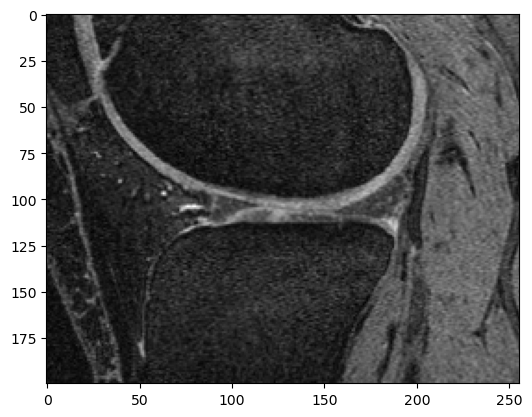

In [9]:
# Get slice 100
slice = sitk.GetArrayFromImage(nii_volume)[100, :, :]

# Plot the slice
plt.imshow(slice, cmap='gray')

In [10]:
# Look at how dimensions of numpy array are ordered
np_volume = sitk.GetArrayFromImage(nii_volume)
print("Numpy array shape:", np_volume.shape)

Numpy array shape: (160, 200, 256)


## Get SKMTEA TEST PATHS

In [11]:
# Define data path to the images
DATA_DIR = '../../../../skmtea/qdess/v1-release/image_files/'

# annotations path
ann_dir_path = DATA_DIR + '../annotations/v1.0.0/'

# Path to the JSON file
file_path = "test.json"

# Open and load the JSON file
with open(ann_dir_path + file_path, "r") as file:
    data = json.load(file)

# Access each part of the JSON structure
info = data["info"]
categories = data["categories"]
images = data["images"]
annotations = data["annotations"]

test_ims_df = pd.DataFrame(images)
test_ims_df.head()

,id,file_name,msp_id,msp_file_name,scan_id,subject_id,timepoint,voxel_spacing,matrix_shape,orientation,num_echoes,inspected
0,1,MTR_005.h5,0000099_V00,0000099_V00.h5,MTR_005,99,0,"[0.3125, 0.3125, 0.8]","[512, 512, 160]","[SI, AP, LR]",2,True
1,2,MTR_006.h5,0000164_V00,0000164_V00.h5,MTR_006,164,0,"[0.3125, 0.3125, 0.8]","[512, 512, 160]","[SI, AP, LR]",2,True
2,3,MTR_030.h5,0000249_V00,0000249_V00.h5,MTR_030,249,0,"[0.3125, 0.3125, 0.8]","[512, 512, 160]","[SI, AP, LR]",2,True
3,4,MTR_034.h5,0000117_V00,0000117_V00.h5,MTR_034,117,0,"[0.3125, 0.3125, 0.8]","[512, 512, 160]","[SI, AP, LR]",2,True
4,5,MTR_048.h5,0000216_V00,0000216_V00.h5,MTR_048,216,0,"[0.3125, 0.3125, 0.8]","[512, 512, 160]","[SI, AP, LR]",2,True


In [20]:
# get paths to the images
image_paths = test_ims_df['file_name'].to_numpy()
print(image_paths.shape)

# get spacing of image (all are the same)
spacing = test_ims_df['voxel_spacing'][0]
print(spacing)

(36,)
[0.3125, 0.3125, 0.8]


In [21]:
# test by loading the first image
im, seg = get_skmtea_im_and_seg(image_paths[0], DATA_DIR)

In [22]:
# look at shape
print("Original shape:", im.shape)

Original shape: (512, 512, 160)


In [23]:
# check mask is binary
print(np.unique(seg))

[0 1]


In [24]:
# do cropping transformation
cropped_im = skmtea_crop_im(im)

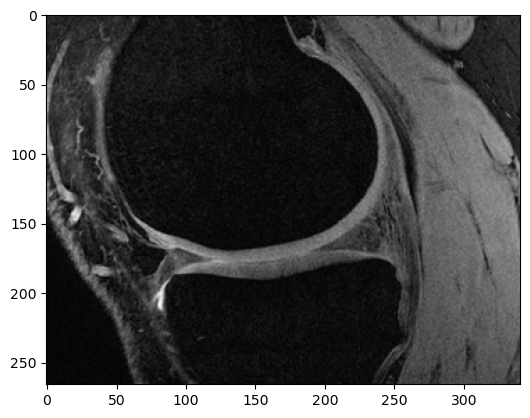

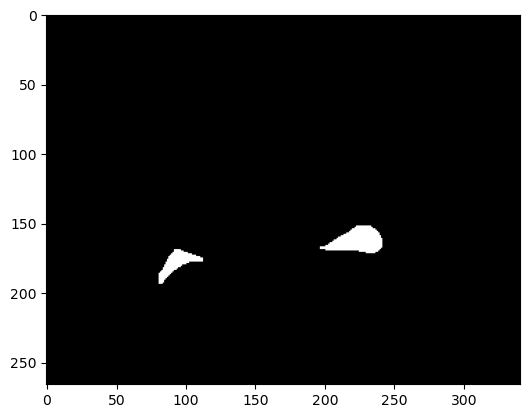

In [25]:
# plot the 100th slice
cropped_slice = cropped_im[:, :, 100]
plt.imshow(cropped_slice, cmap='gray')
plt.show()

plt.imshow(skmtea_crop_im(seg)[:, :, 100], cmap='gray')
plt.show()

In [26]:
# reorder dimensions of original volume, moving slice axis to front
reordered_im = np.moveaxis(cropped_im, -1, 0)

In [27]:
reordered_im.shape

(160, 266, 341)

In [28]:
# turn reordered original into sitk image
reordered_im_sitk = sitk.GetImageFromArray(reordered_im)

In [29]:
# set metadata of reordered original to be the same as nii volume
reordered_im_sitk.SetSpacing(spacing)

In [30]:
reordered_im_sitk.GetSpacing()

(0.3125, 0.3125, 0.8)

In [31]:
reordered_im_sitk.GetSize()

(341, 266, 160)

## Now transform test images and masks, and save in imagesTs and labelsTs

In [21]:
# data directory path
nnunet_data_dir = '../../data/nnUNet_raw/Dataset361_Menisci/'

# make imagesTsExt and labelsTsExt dirs
os.makedirs(nnunet_data_dir + 'imagesTs_skmtea', exist_ok=True)
os.makedirs(nnunet_data_dir + 'labelsTs_skmtea', exist_ok=True)

In [22]:
# Write full loop to convert all test images and masks to .nii.gz format
# Then input spacing metadata
# Save to nnUNet_raw/Dataset361_Menisci/imagesTs and labelsTs
image_save_path = nnunet_data_dir + 'imagesTs_skmtea/'
mask_save_path = nnunet_data_dir + 'labelsTs_skmtea/'

for i in range(len(image_paths)):
    # Load image
    test_image, test_mask = get_skmtea_im_and_seg(image_paths[i], DATA_DIR)
    
    # Crop image and mask
    cropped_image = skmtea_crop_im(test_image)
    cropped_mask = skmtea_crop_im(test_mask)
    
    # Reorder dimensions
    reordered_image = np.moveaxis(cropped_image, -1, 0)
    reordered_mask = np.moveaxis(cropped_mask, -1, 0)
    
    # Turn into sitk image
    sitk_image = sitk.GetImageFromArray(reordered_image)
    sitk_mask = sitk.GetImageFromArray(reordered_mask)
    
    # Set spacing
    sitk_image.SetSpacing(spacing)
    sitk_mask.SetSpacing(spacing)
    
    # Save image, padding number to always be 3 digits using zeros to the left
    sitk.WriteImage(sitk_image, image_save_path + f'SKMTEA_{str(i+1).zfill(3)}_0000.nii.gz')
    
    # Save mask
    sitk.WriteImage(sitk_mask, mask_save_path + f'SKMTEA_{str(i+1).zfill(3)}.nii.gz')

(0.3125, 0.3125, 0.800000011920929)
(0.3125, 0.3125, 0.800000011920929)
(160, 266, 341)
(160, 266, 341)


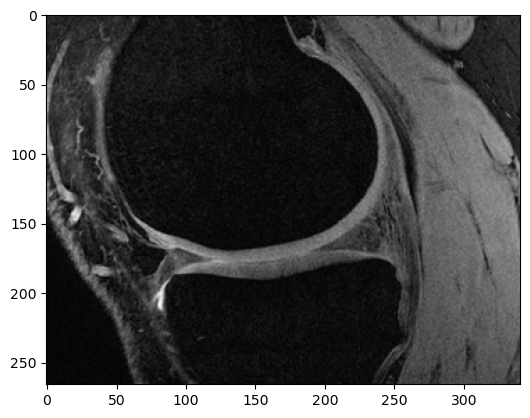

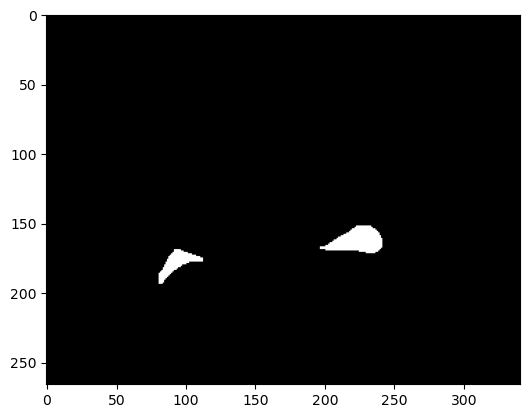

In [23]:
# check that the images and masks have been saved correctly by loading the first case of each
first_image = sitk.ReadImage(image_save_path + 'SKMTEA_001_0000.nii.gz')
first_mask = sitk.ReadImage(mask_save_path + 'SKMTEA_001.nii.gz')

# check that the spacing is correct
print(first_image.GetSpacing())
print(first_mask.GetSpacing())

# check that the shapes are correct
print(sitk.GetArrayFromImage(first_image).shape)
print(sitk.GetArrayFromImage(first_mask).shape)

# plot slice 100 of both
plt.imshow(sitk.GetArrayFromImage(first_image)[100, :, :], cmap='gray')
plt.show()
plt.imshow(sitk.GetArrayFromImage(first_mask)[100, :, :], cmap='gray')
plt.show()

In [24]:
# check pixel value type
print(sitk.GetArrayFromImage(first_image).dtype)

# print pixel value
print(sitk.GetArrayFromImage(first_image)[100, 100, 100].astype(np.float32))

float32
242.75914


In [25]:
# check pixel value type of previous nii image
print(np_volume.dtype)

# print pixel value
print(np_volume[100, 100, 100])

float32
0.0019989319


In [12]:
# Let's do the same for all images
def get_paths_from_json(json_path):
    with open(json_path, "r") as file:
        data = json.load(file)
    images_df = pd.DataFrame(data["images"])
    image_paths = images_df['file_name'].to_numpy()
    return image_paths

In [16]:
file_paths = ['train.json', 'val.json', 'test.json']

# return paths from each json and concatenate
all_image_paths = np.array([])

for file_path in file_paths:
    image_paths = get_paths_from_json(ann_dir_path + file_path)
    all_image_paths = np.concatenate((all_image_paths, image_paths))

# check that the number of images is correct
print(len(all_image_paths))
# sort the paths
all_image_paths = np.sort(all_image_paths)

155


In [18]:
# data directory path
nnunet_data_dir = '../../data/nnUNet_raw/Dataset361_Menisci/'

# make imagesTsExt and labelsTsExt dirs
os.makedirs(nnunet_data_dir + 'images_all_skmtea', exist_ok=True)
os.makedirs(nnunet_data_dir + 'labels_all_skmtea', exist_ok=True)

In [32]:
# Write full loop to convert all test images and masks to .nii.gz format
# Then input spacing metadata
# Save to nnUNet_raw/Dataset361_Menisci/imagesTs and labelsTs
image_save_path = nnunet_data_dir + 'images_all_skmtea/'
mask_save_path = nnunet_data_dir + 'labels_all_skmtea/'

from tqdm import tqdm

for i in tqdm(range(len(all_image_paths))):
    # Load image
    test_image, test_mask = get_skmtea_im_and_seg(all_image_paths[i], DATA_DIR)
    
    # Crop image and mask
    cropped_image = skmtea_crop_im(test_image)
    cropped_mask = skmtea_crop_im(test_mask)
    
    # Reorder dimensions
    reordered_image = np.moveaxis(cropped_image, -1, 0)
    reordered_mask = np.moveaxis(cropped_mask, -1, 0)
    
    # Turn into sitk image
    sitk_image = sitk.GetImageFromArray(reordered_image)
    sitk_mask = sitk.GetImageFromArray(reordered_mask)
    
    # Set spacing
    sitk_image.SetSpacing(spacing)
    sitk_mask.SetSpacing(spacing)
    
    # Save image, padding number to always be 3 digits using zeros to the left
    sitk.WriteImage(sitk_image, image_save_path + f'SKMTEA_{str(i+1).zfill(3)}_0000.nii.gz')
    
    # Save mask
    sitk.WriteImage(sitk_mask, mask_save_path + f'SKMTEA_{str(i+1).zfill(3)}.nii.gz')

100%|██████████| 155/155 [23:05<00:00,  8.94s/it]


(0.3125, 0.3125, 0.800000011920929)
(0.3125, 0.3125, 0.800000011920929)
(160, 266, 341)
(160, 266, 341)


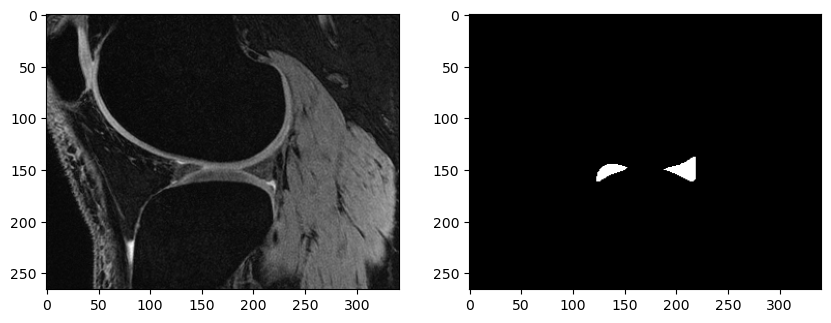

In [33]:
# check that the images and masks have been saved correctly by loading the first case of each
first_image = sitk.ReadImage(image_save_path + 'SKMTEA_001_0000.nii.gz')
first_mask = sitk.ReadImage(mask_save_path + 'SKMTEA_001.nii.gz')

# check that the spacing is correct
print(first_image.GetSpacing())
print(first_mask.GetSpacing())

# check that the shapes are correct
print(sitk.GetArrayFromImage(first_image).shape)
print(sitk.GetArrayFromImage(first_mask).shape)

# plot slice 100 of both side by side
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(sitk.GetArrayFromImage(first_image)[100, :, :], cmap='gray')
ax[1].imshow(sitk.GetArrayFromImage(first_mask)[100, :, :], cmap='gray')
plt.show()